In [1]:
import openpnm as op
print(op.__version__)

2.1.0b1


In [2]:
import os
import openpnm as op
import pickle
import numpy as np
import porespy as ps

In [3]:
import matplotlib.pyplot as plt

In [4]:
files = [
    'image3d_Urna30_CAC',
    'ceramics_500cube_kriging',
    'carb71_s720cube_CAC',
    'soil_Ah-1_700cube_kiging',
    'carb_96558_720cube_CAC',
    'Urna22_710cube_CAC',
]

In [5]:
dir_name = 'calc_results'

In [6]:
fname = files[4]

In [7]:
fname

'carb_96558_720cube_CAC'

In [8]:
with open(fname, 'rb') as f:
    pn_extracted = pickle.load(f)

In [9]:
pn = op.network.GenericNetwork()
pn.update(pn_extracted)

In [10]:
h = pn.check_network_health()

In [11]:
op.topotools.trim(pn, pores=h['trim_pores'])

―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
    SOURCE: openpnm.topotools.topotools._scale_3d_axes 
    TIME STAMP: 2019-08-23 10:07:33,232    


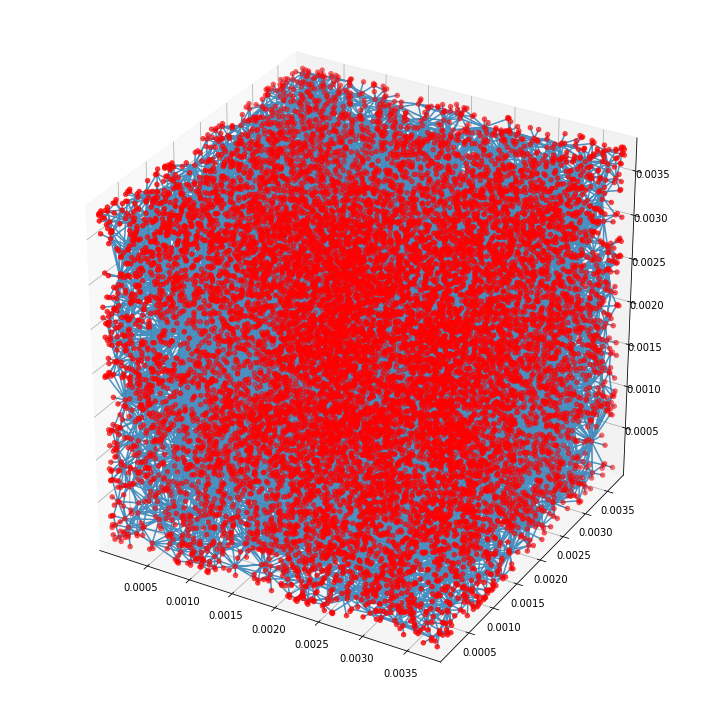

In [12]:
fig = op.topotools.plot_connections(network=pn, alpha=0.8)
fig = op.topotools.plot_coordinates(network=pn, fig=fig, color='r')
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.savefig('3.jpg')

In [13]:
from utils import Imported

In [14]:
geom = Imported(pn)

In [15]:
hg = op.phases.Mercury(network=pn, name='mercury')

In [16]:
hg['pore.surface_tension'] = 30 * 1e-3
hg['pore.viscosity'] = 1.39 * 1e-3
hg['pore.density'] = 850
hg['pore.contact_angle'] = 180.0
geom['pore.volume'][pn.pores('left')] = 0.0

In [17]:
phys = op.physics.GenericPhysics(network=pn, phase=hg, geometry=geom)
phys.add_model(propname='throat.entry_pressure',
               model=op.models.physics.capillary_pressure.washburn)

In [18]:
# a = op.algorithms.OrdinaryPercolation(network=pn, phase=hg, settings={'access_limited': False})
# a.set_inlets(pores=pn.pores('left'), overwrite=True)
# a.run(points=100)
# a.get_intrusion_data()

In [19]:
mip = op.algorithms.Porosimetry(network=pn, phase=hg)
mip.set_inlets(pores=pn.pores('left'), overwrite=True)
mip.run(points=100)

In [20]:
data = mip.get_intrusion_data()

In [21]:
x = (0.073754 - 0.05045) / 0.073754
x = 0.259
x

0.259

In [23]:
# x = (0.098103 - 0.084112) / 0.098103
# x = 0.12581
# x

0.12581

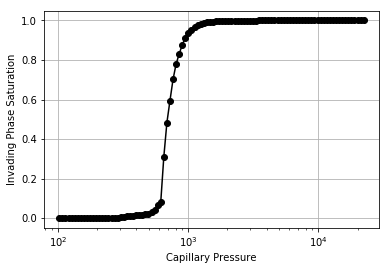

In [22]:
fig = mip.plot_intrusion_curve()
plt.savefig(os.path.join(dir_name, '{}.jpg'.format(fname)))

In [23]:
import pandas as pd

In [24]:
df = pd.DataFrame(data={'Pcap': data.Pcap, 'Snwp': data.Snwp}, columns=['Pcap', 'Snwp'])
df['Snwp'] = df['Snwp'] * (1 - x) + x

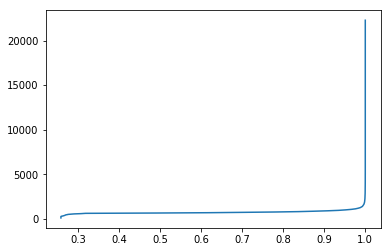

In [25]:
plt.plot(df.Snwp, df.Pcap)
plt.show()

In [26]:
df.to_csv(os.path.join(dir_name, fname + '.csv'), encoding='utf-8')